In [46]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [47]:
# Define the data for the first coin produced by the factory
# We take this coin, flip it 100 times, and observe 57 heads and 43 tails
x = 57
n = 100

# Define the Likelihood P(x|p) - binomial distribution
def likelihood(p):
    return stats.binom.pmf(x, n, p)

In [48]:
# Define the prior P(p) - as we have never seen this coin before, we will assume a uniform distribution
def prior(p):
    return stats.uniform.pdf(p)

for i in range(10):
    print(i*0.1, prior(i*0.1))

0.0 1.0
0.1 1.0
0.2 1.0
0.30000000000000004 1.0
0.4 1.0
0.5 1.0
0.6000000000000001 1.0
0.7000000000000001 1.0
0.8 1.0
0.9 1.0


# The Metropolis-Hastings MCMC

As mentioned above, these methods draw samples from a continuous random variable — in our case for p. The MCMC we will use is of the random walk type, which randomly generates samples and keeps them or not based on how they fit the model.

The Metropolis-Hastings algorithm is a Markov Chain Monte Carlo method for obtaining a sequence of random samples from a probability distribution for which direct sampling is difficult. This sequence can be used to approximate the distribution (e.g. to generate a histogram of the distribution); for example, the sequence can be used to approximate the posterior distribution in Bayesian inference.

The algorithm is as follows:

1. Propose a new value of p randomly between 0 and 1, call it p′ (or p_new).
2. Compute the acceptance ratio, R.
3. Generate another uniform random number between 0 and 1, call it u.
4. If u < R, accept the new value and set p = p′. Otherwise, keep the current value of p.
5. Record the final value of p for this sample.
6. Repeat steps 1 through 5 many, many times.

# Acceptance Ratio

The Metropolis-Hastings algorithm is fairly straightforward, but first, we need to define how we will either accept or reject the new sample draw. Each iteration, a new value for p between 0 and 1 will be proposed, we will call this proposed value p′. We only want to accept and update this value if it is better than the previous. This is done by computing an acceptance ratio, R. This acceptance ratio is the ratio of our Bayes’ Theorem for the proposed value over the previous value and is shown below.




In [49]:
# Define the acceptance ratio

def acceptance_ratio(p, p_new):
    return min(1, likelihood(p_new) * prior(p_new) / (likelihood(p) * prior(p)))

# Burn-in

MCMCs are initialized randomly and must converge towards the correct value, and this can often take quite a lot of samples. When plotting our results and posterior distribution, it is not effective to include these early samples before the model has converged. So we implement what is called a “burn-in”, in which those first, less accurate samples are excluded. Burn-in for MCMCs is typically around 2000–5000 samples when the entire chain is around 10k–20k.

# Lag

Another very important thing to consider with MCMCs is sample independence. A new sample here is often dependent on the previous one as occasionally we do not accept a new random value and keep the old. To address this problem, we implement what is called “lag”. Lag is where rather than recording every sample, we record every other, or perhaps every fifth or tenth sample.

# The Simulation

Great, we now have everything we need to write and run our MCMC.


In [50]:
# Create empty list to store samples
results = []

# Initialize a value of p
p = np.random.uniform(0, 1)

# Define model parameters
n_samples = 25000
burn_in = 5000
lag = 5

# Create the MCMC loop
for i in range(n_samples):
    # Propose a new value of p randomly from a uniform distribution between 0 and 1
    p_new = np.random.random_sample()
    # Compute acceptance probability
    R = acceptance_ratio(p, p_new)
    # Draw random sample to compare R to
    u = np.random.random_sample()
    # If R is greater than u, accept the new value of p (set p = p_new)
    if u < R:
        p = p_new
    # Record values after burn in - how often determined by lag
    if i > burn_in and i%lag == 0:
        results.append(p)

(array([0.07041079, 0.0352054 , 0.07041079, 0.17602698, 0.17602698,
        0.24643778, 0.14082159, 0.31684857, 0.45767016, 0.88013492,
        1.26739429, 1.1617781 , 2.14752921, 2.14752921, 3.48533429,
        3.3797181 , 4.04862064, 6.30176604, 5.31601492, 6.44258762,
        7.70998191, 7.11149016, 8.55491143, 7.21710635, 7.56916032,
        9.39984096, 7.35792794, 6.54820381, 5.91450667, 6.75943619,
        5.49204191, 5.10478254, 3.76697746, 3.41492349, 2.2883508 ,
        1.72506445, 2.00670762, 1.72506445, 0.88013492, 0.59849175,
        0.56328635, 0.31684857, 0.21123238, 0.0352054 , 0.14082159,
        0.07041079, 0.        , 0.        , 0.        , 0.0352054 ]),
 array([0.3973432 , 0.40444616, 0.41154912, 0.41865208, 0.42575504,
        0.432858  , 0.43996096, 0.44706392, 0.45416688, 0.46126984,
        0.4683728 , 0.47547576, 0.48257872, 0.48968168, 0.49678464,
        0.5038876 , 0.51099056, 0.51809352, 0.52519648, 0.53229944,
        0.5394024 , 0.54650536, 0.55360831, 0.

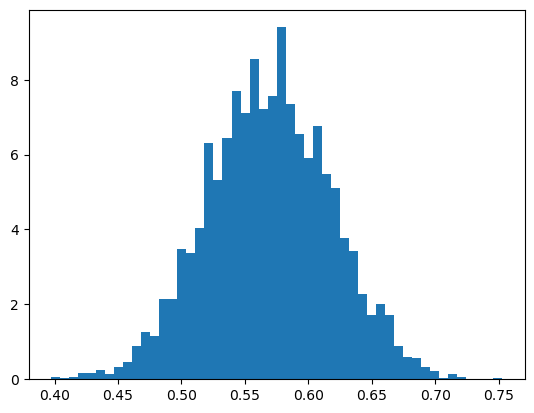

In [51]:
plt.hist(results, bins=50, density=True)

In [52]:
print("Mean: ", np.mean(results))
print("Standard Deviation: ", np.std(results))

print("Expected Mean: ", x/n)
print("Expected Standard Deviation: ", np.sqrt(x/n*(1-x/n)/n))

Mean:  0.5690728035515621
Standard Deviation:  0.04879207928888652
Expected Mean:  0.57
Expected Standard Deviation:  0.04950757517794625


# Next Steps

### Okay, so now let's suppose that the factory makes five hundred more coins. We do the same procedure of 100 flips (testing) for each of these coins, and determine a probability of heads for each. We can then use these probabilities as our prior for the next round of testing. This is the beauty of Bayesian statistics, we can update our prior with new information and get a better estimate of the true probability of heads.

### Let's suppose that when we do this, we find that there is a distribution of probabilities for the five hundred coins that looks like this:  it is a roughly normal distribution with a mean of 0.511 and a standard deviation of 0.015. We can use this as our prior for the next round of testing.

In [59]:
# Expected mean and standard deviation of 500 fair coins
print("Expected Mean: ", 0.5)
print("Expected Standard Deviation: ", np.sqrt(0.5*(1-0.5)/500))

print("Expected Standard Deviation for coin with mu=0.511: ", np.sqrt(0.511*(1-0.511)/500))

# Define the prior P(p) - using the mean and standard deviation of the distribution of probabilities for the 500 coins
# Note that we are using here the OBSERVED mean and standard deviation of the 500 coins, not the expected mean 
# and standard deviation of 500 fair coins ... that is, we are using the SAMPLE values, and not the expected 
# POPULATION values

mean = 0.511
std = 0.015

def prior(p):
    return stats.norm.pdf(p, mean, std)


Expected Mean:  0.5
Expected Standard Deviation:  0.022360679774997897
Expected Standard Deviation for coin with mu=0.511:  0.02235526783556842


In [60]:
# Now, look at the 501st coin

x = 63
n = 100

# Likelihood function - Binomial
def likelihood(p):
    return stats.binom.pmf(x, n, p)

def acceptance_ratio(p, p_new):
    return min(1, likelihood(p_new) * prior(p_new) / (likelihood(p) * prior(p)))


In [61]:
# Create empty list to store samples
results2 = []

# Initialize a value of p
p = np.random.uniform(0, 1)

# Define model parameters
n_samples = 25000
burn_in = 5000
lag = 5

# Create the MCMC loop
for i in range(n_samples):
    # Propose a new value of p randomly from a uniform distribution between 0 and 1
    p_new = np.random.random_sample()
    # Compute acceptance probability
    R = acceptance_ratio(p, p_new)
    # Draw random sample to compare R to
    u = np.random.random_sample()
    # If R is greater than u, accept the new value of p (set p = p_new)
    if u < R:
        p = p_new
    # Record values after burn in - how often determined by lag
    if i > burn_in and i%lag == 0:
        results2.append(p)

(array([ 1.07444186,  0.13430523,  0.        ,  0.26861047,  0.8058314 ,
         4.16346221,  1.47735756,  1.74596802,  2.82040988,  4.96929361,
         5.775125  ,  5.775125  ,  4.83498837,  7.52109302, 11.55025   ,
        20.01147966, 14.63927035, 20.54870059, 13.56482849, 21.35453198,
        26.59243605, 35.0536657 , 19.20564826, 36.53102326, 21.62314245,
        26.86104652, 29.14423547, 27.12965698, 21.75744768, 19.07134303,
        24.84646803, 16.78815407,  8.19261919, 17.99690117, 25.51799419,
         9.26706105,  5.64081977,  4.43207268,  3.08902035,  6.71526163,
         4.43207268,  2.41749419,  0.26861047,  0.        ,  0.67152616,
         0.26861047,  0.        ,  0.        ,  0.        ,  0.53722093]),
 array([0.47530143, 0.47716332, 0.47902522, 0.48088712, 0.48274901,
        0.48461091, 0.48647281, 0.4883347 , 0.4901966 , 0.4920585 ,
        0.4939204 , 0.49578229, 0.49764419, 0.49950609, 0.50136798,
        0.50322988, 0.50509178, 0.50695368, 0.50881557, 0.510677

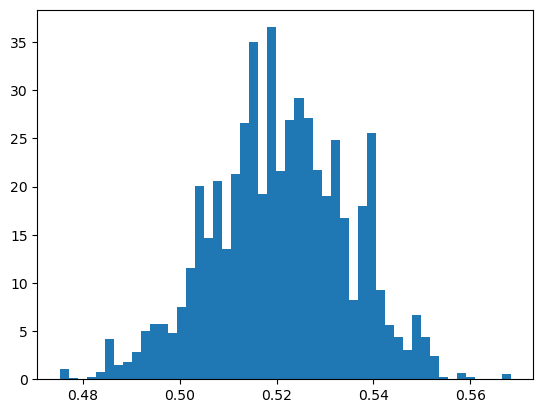

In [62]:
plt.hist(results2, bins=50, density=True)

In [63]:
print("Mean: ", np.mean(results2))
print("Standard Deviation: ", np.std(results2))

print("Expected Mean: ", (500*0.511 + x/n)/(500+1))


Mean:  0.520836145813496
Standard Deviation:  0.01409337044725349
Expected Mean:  0.5112375249500998


# Conclusion

### Even though the data for this coin suggests a bias around 0.63, our Bayesian Inference model suggests the actual value is much closer to 0.52. 

### This is because our informed prior function holds weight in the model, telling us that even if we observed 63 heads for this coin, given that coins are produced with an average bias of around 0.51, we expect the bias for the 501st to be closer to the factory bias. 

### Even if this coin had exactly a 0.5 bias, observing 63 heads out of 100 tosses is not entirely unlikely, and we shouldn't assume this data to be representative of the exact value. The prior function holds weight just like the likelihood does in informing the posterior distribution. 

### If we were to produce thousands of more coins and inform the prior distribution even more, this would give it an even higher weight in the model. This idea of updating our understanding with more information to predict unknown parameters is exactly why Bayesian Inference is useful. It is tuning and manipulating these likelihood and prior functions with more and better data that allows us to improve and inform our inference model.